In [1]:
import os
import torch          # PyTorch
import numpy as np    # Numpy
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import genfromtxt

import sys
sys.path.insert(1, '../../miscelaneous')
from spinnorse_tools import fetch_files, plot_iho

from norse.torch.module.lif import LIFFeedForwardCell, LIFFeedForwardLayer
from norse.torch.functional.lif import LIFParameters, LIFState, LIFFeedForwardState

In [2]:
# Timestep and Sim Duration in seconds
dt = 0.001

# Cell parameters
p=LIFParameters(tau_syn_inv=torch.tensor(1000/5.0),
                tau_mem_inv=torch.tensor(1000/20.0), 
                v_leak=torch.tensor(-65.0),
                v_th=torch.tensor(-50.0),
                v_reset=torch.tensor(-65.0), 
                method='super',
                alpha=torch.tensor(0.))


In [3]:
class Pathway_1D(torch.nn.Module):
    def __init__(self):
        super(Pathway_1D, self).__init__()     
        
        self.w = 19.07 #19.07 one spike
        
        self.ratio = 1 #  
        self.nb_hl = 1 # nb of hidden layers
        self.nb_nol = 1 #nb of neurons in output layer
        self.nb_nhl = 1 #nb of neurons in hidden layer
        self.nb_nil = 1 #nb of neurons in input layer
        
        self.fcnn_h = torch.nn.Linear(self.nb_nil, self.nb_nhl)
        self.lif_h_layer = LIFFeedForwardLayer(p,dt)
        self.fcnn_o = torch.nn.Linear(self.nb_nhl, self.nb_nol)
        self.lif_o_layer = LIFFeedForwardLayer(p,dt)
        
    def forward(self, i_spikes):        
        nb_steps = i_spikes.shape[0]
        
        s_hl = LIFFeedForwardState(v=-65.0*torch.ones(1, self.nb_nhl), i=torch.zeros(1, self.nb_nhl))
        s_ol = LIFFeedForwardState(v=-65.0*torch.ones(1, self.nb_nol), i=torch.zeros(1, self.nb_nol))
        
        v_hl = np.zeros((nb_steps,self.nb_nhl))
        v_ol = np.zeros((nb_steps,self.nb_nol))
        
        o_spikes_hl = np.zeros((nb_steps,self.nb_nhl))
        o_spikes_ol = np.zeros((nb_steps,self.nb_nol))
        
        self.fcnn_h.weight.data.fill_(self.w)
        self.fcnn_h.bias.data.fill_(0)
        self.fcnn_o.weight.data.fill_(self.w)
        self.fcnn_o.bias.data.fill_(0)
        
       
        
        for ts in range(nb_steps):
            z_il =  torch.reshape(torch.from_numpy(i_spikes[ts,:]),(1,self.nb_nil)).float()
            z_hl = self.fcnn_h(z_il)                
            z_hl, s_hl = self.lif_h_layer(z_hl, s_hl)
            o_spikes_hl[ts,:] = z_hl.detach().numpy()
            v_hl[ts,:] = s_hl.v.detach().numpy()
            z_ol = self.fcnn_o(z_hl)
            z_ol, s_ol = self.lif_o_layer(z_ol, s_ol)
            o_spikes_ol[ts,:] = z_ol.detach().numpy()
            v_ol[ts,:] = s_ol.v.detach().numpy()
        return  o_spikes_ol, v_ol, o_spikes_hl, v_hl
            
        


In [4]:
# Describe Architecture
nb_steps = 200

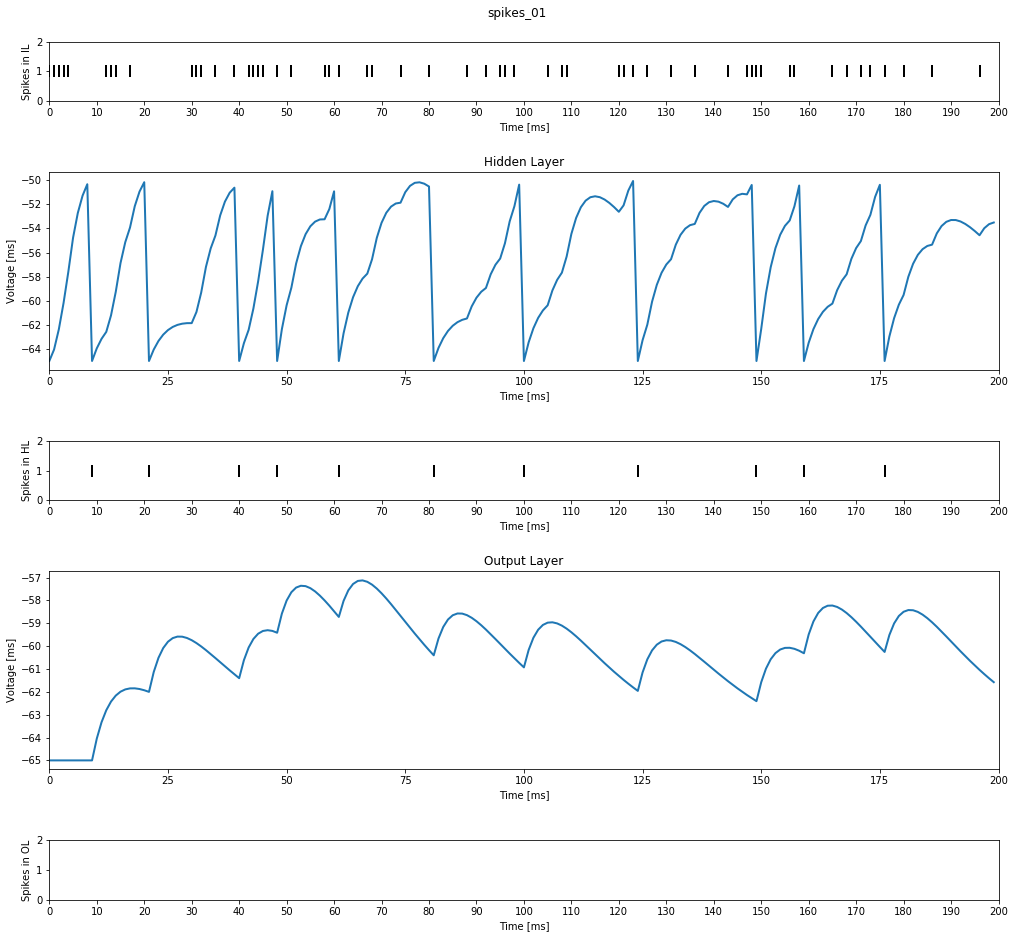

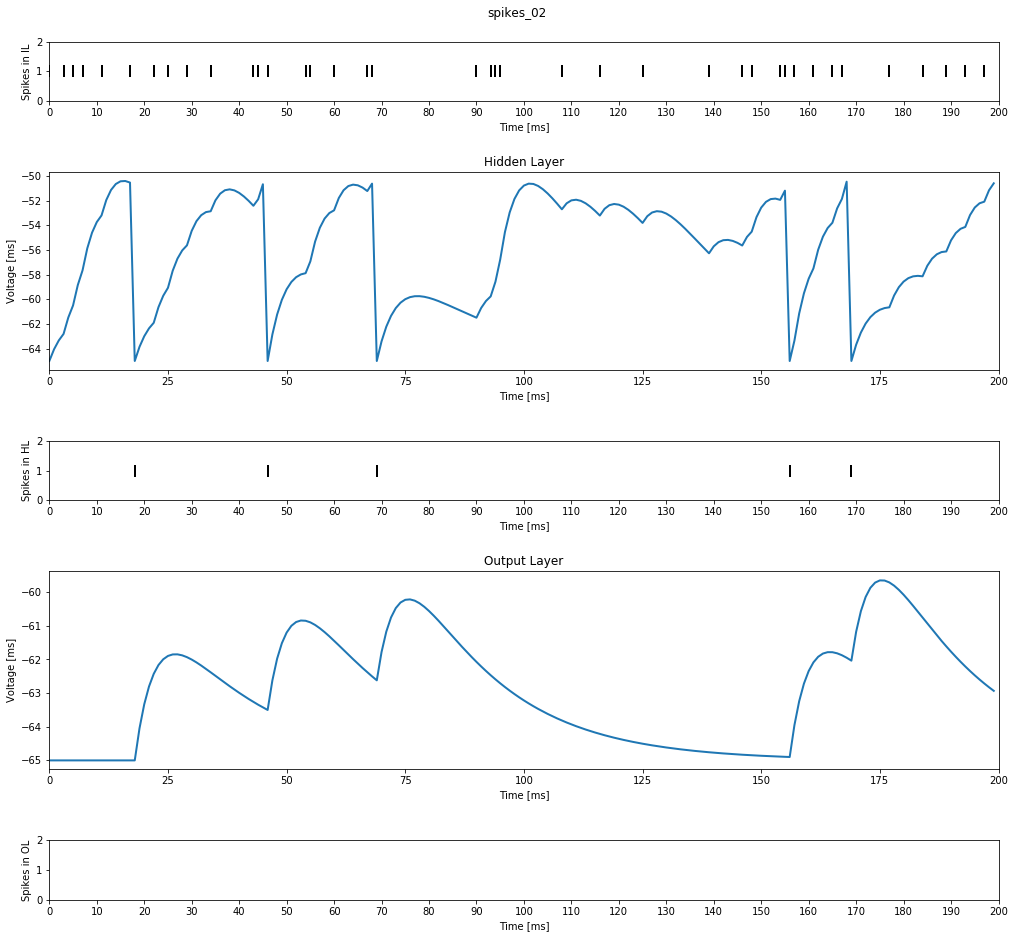

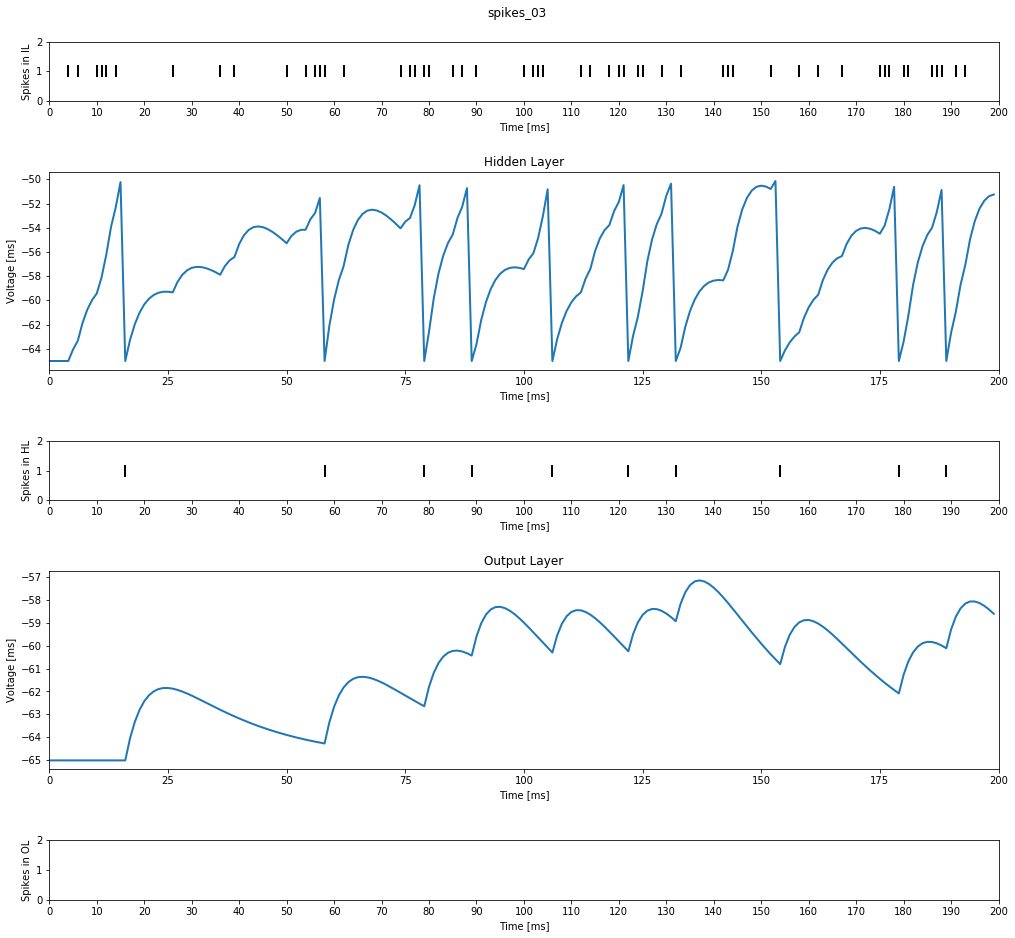

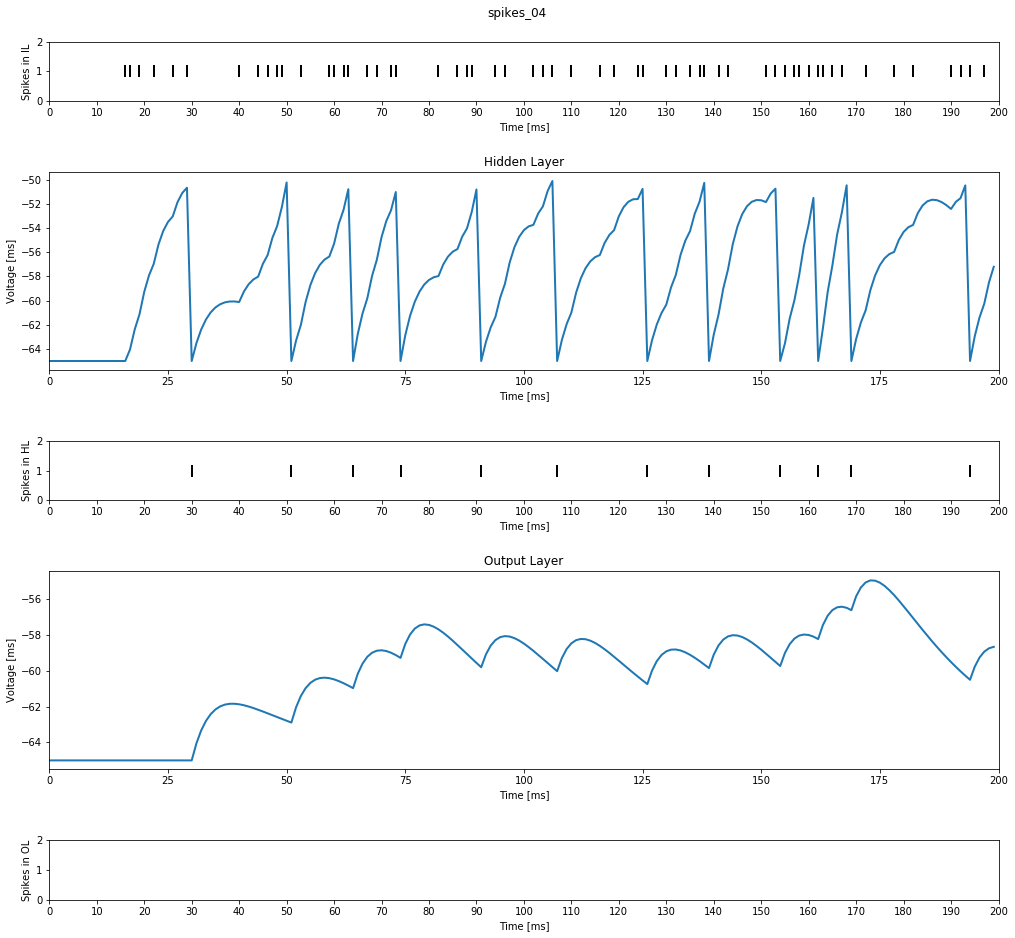

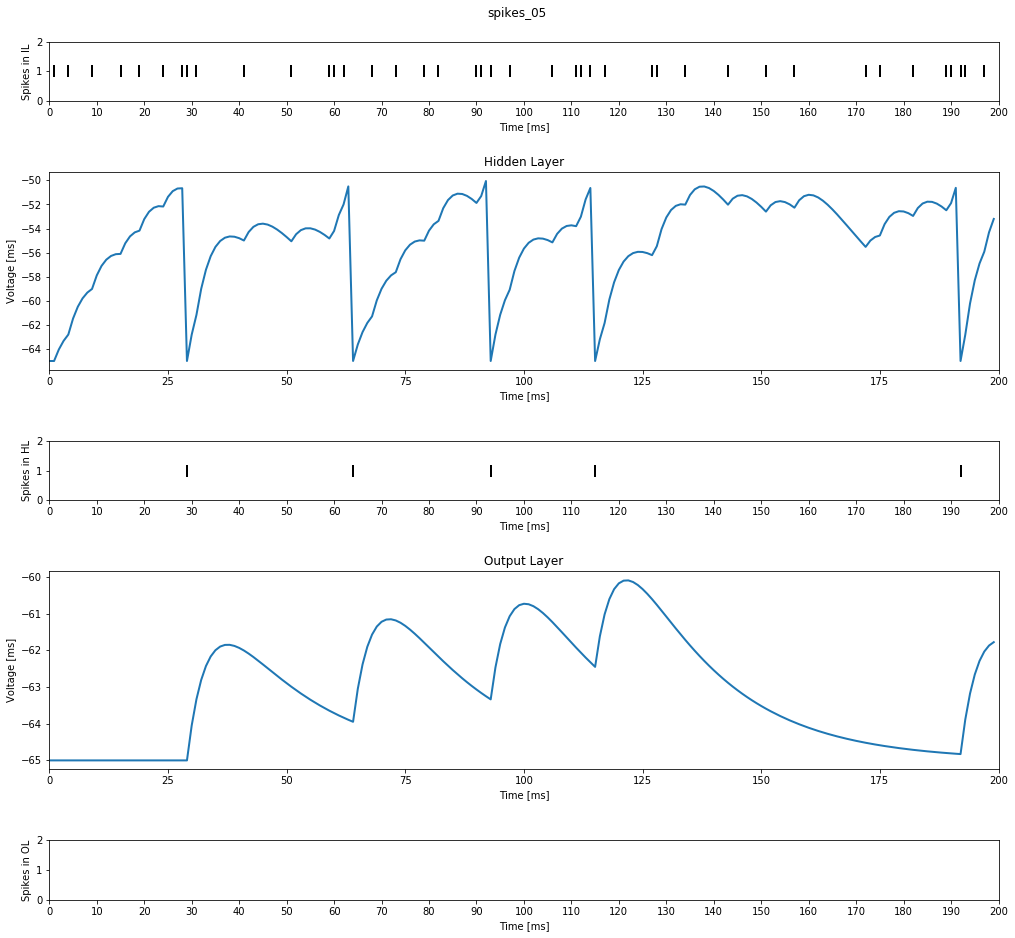

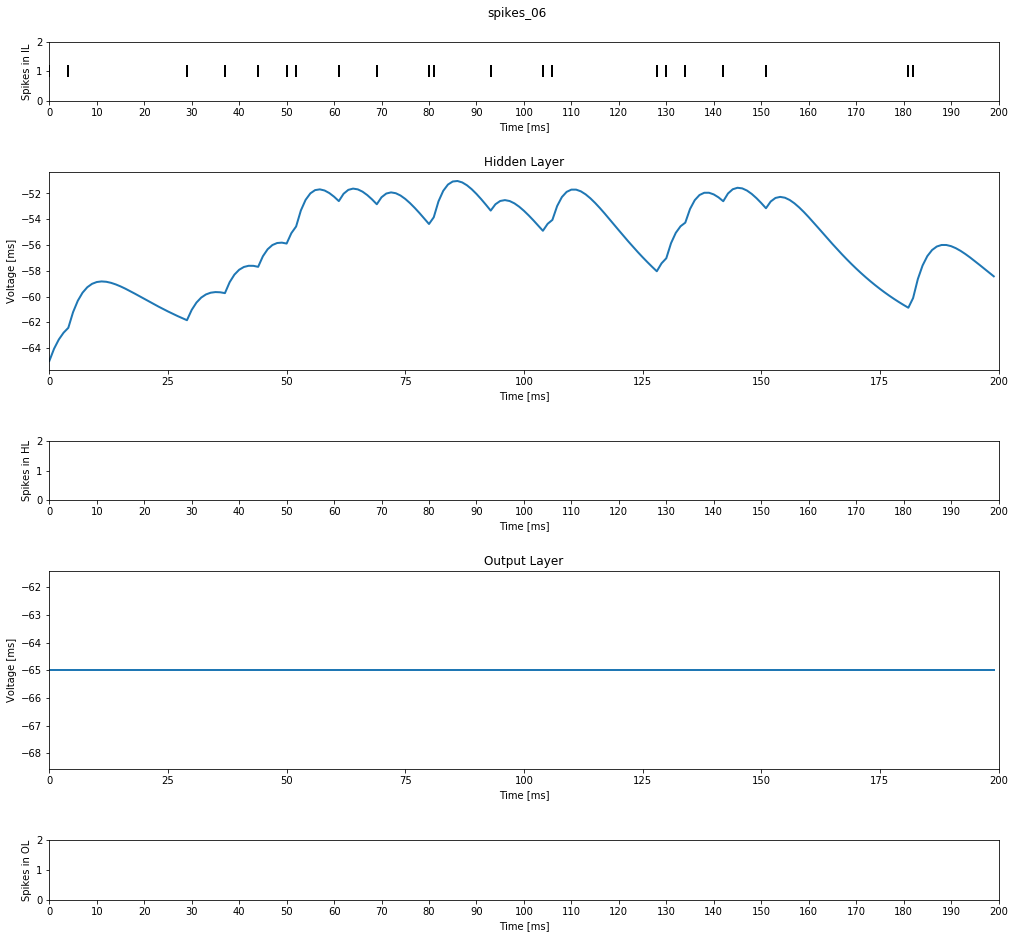

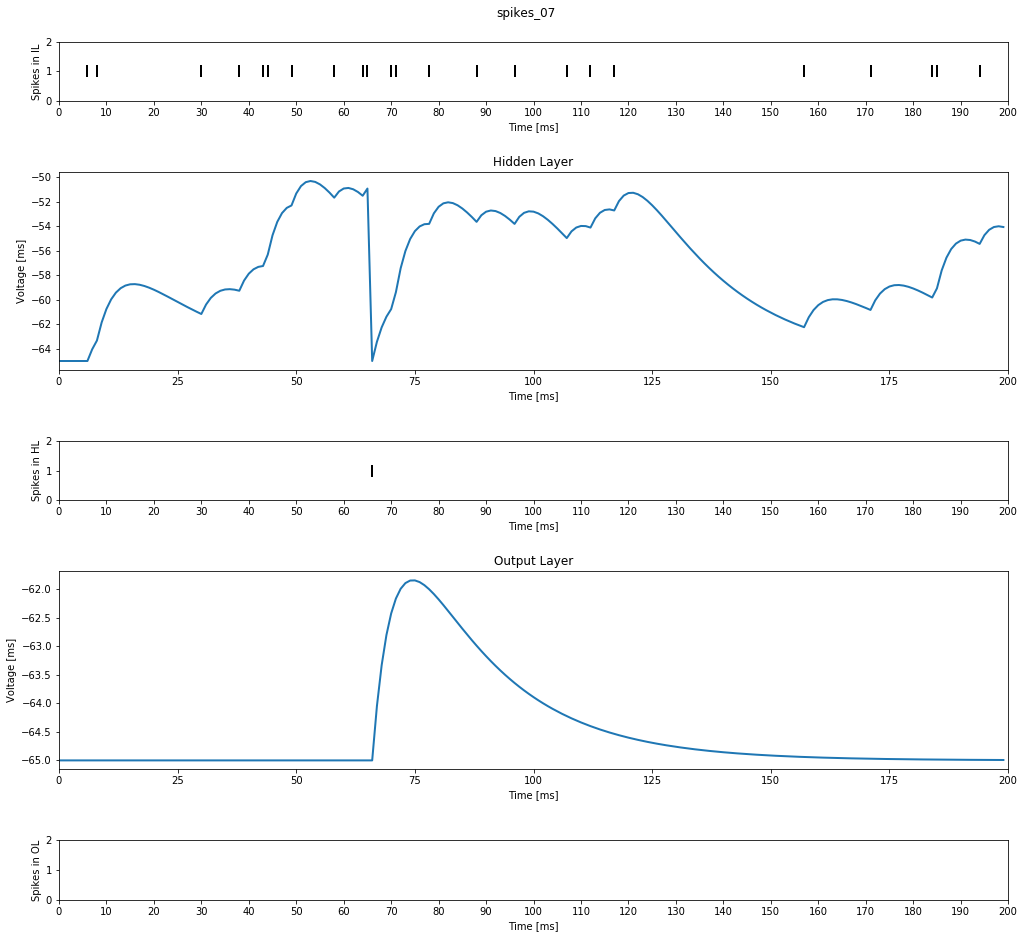

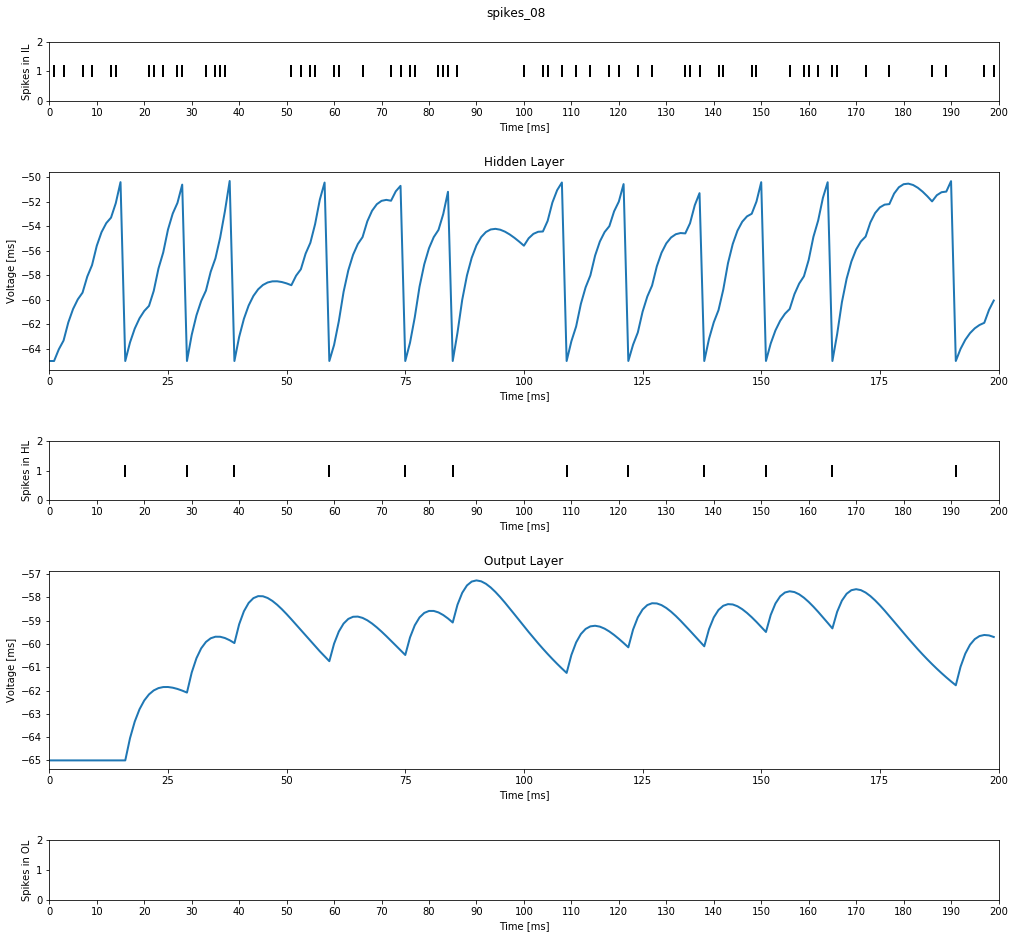

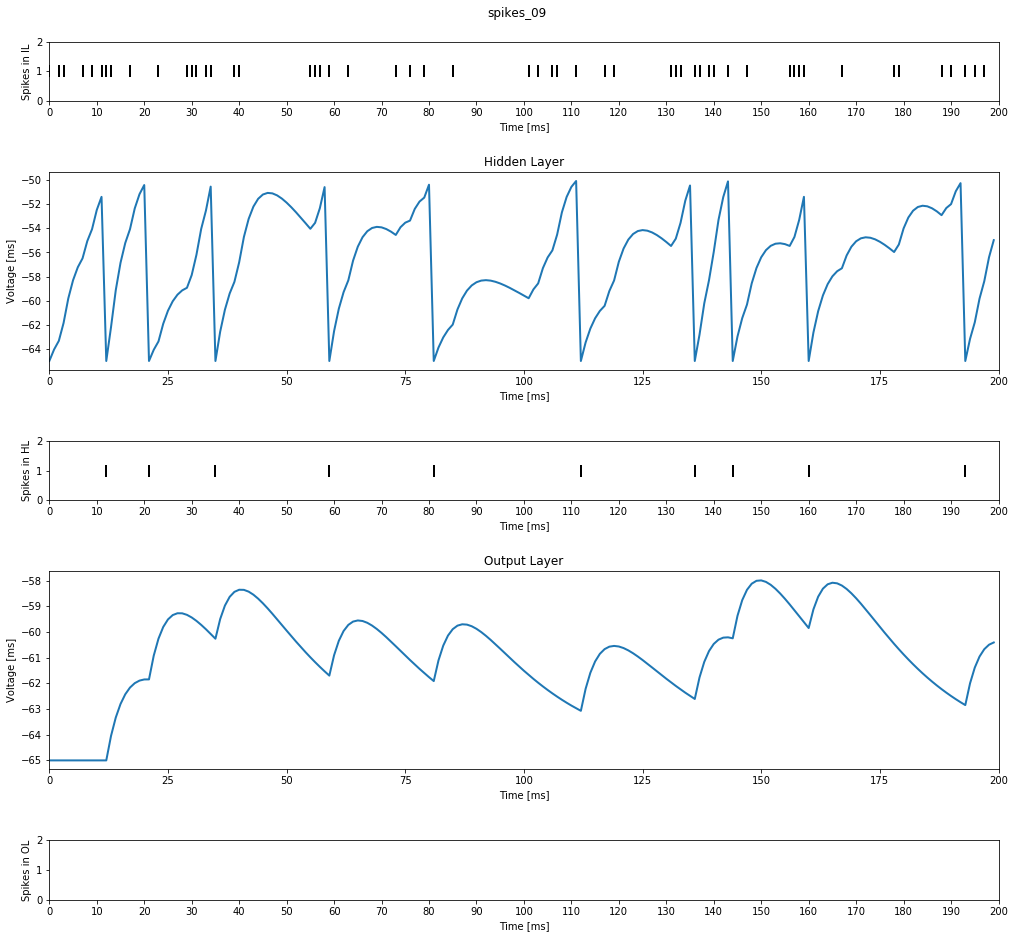

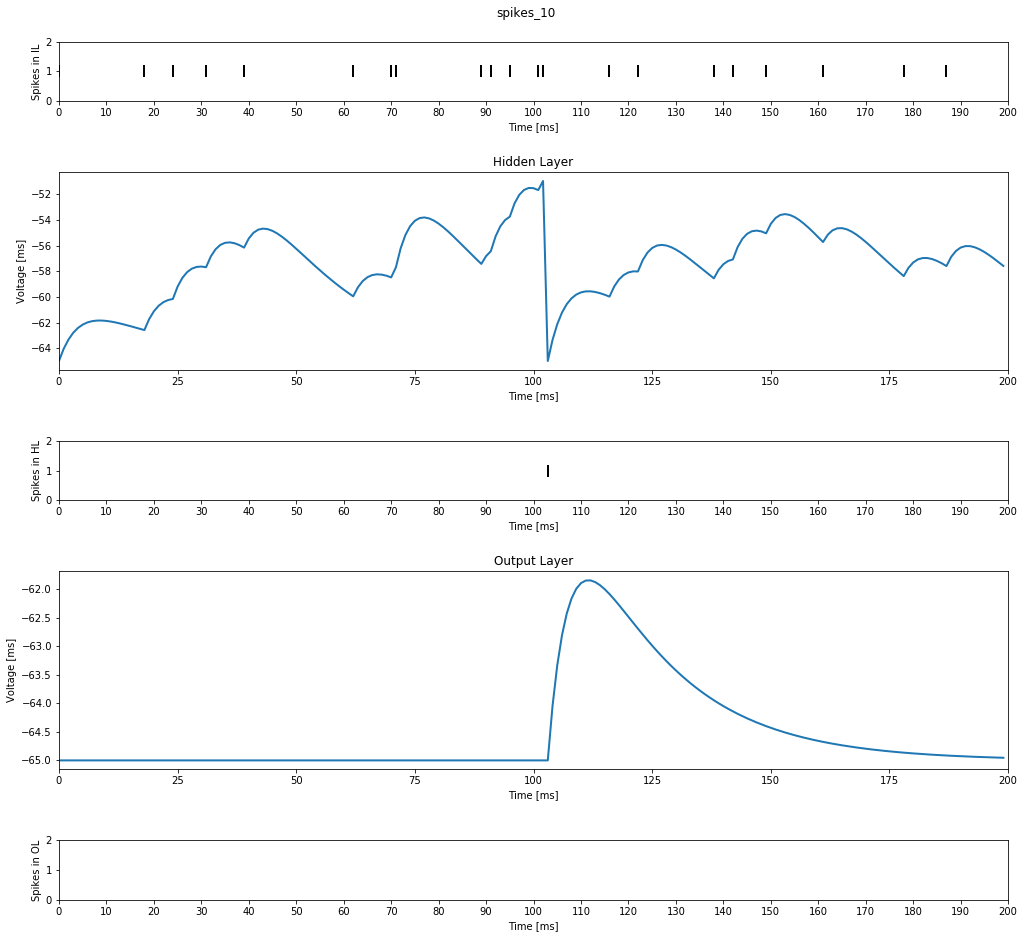

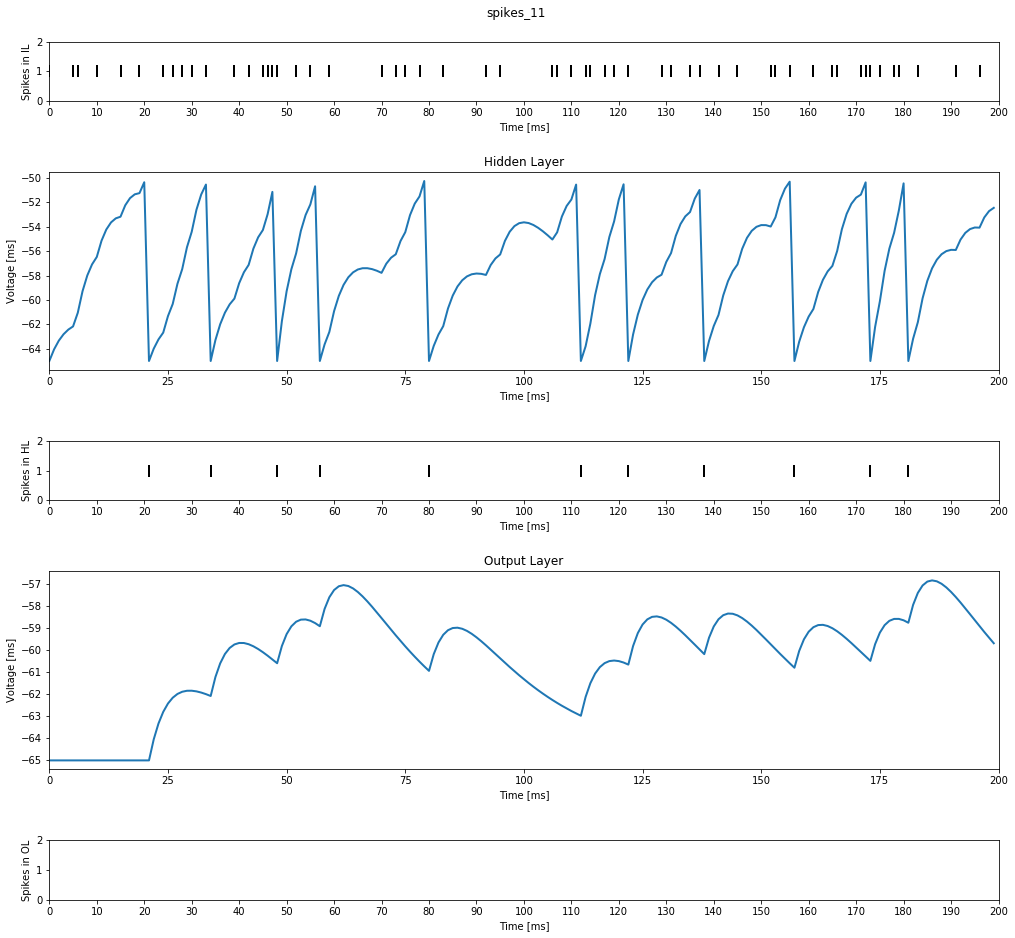

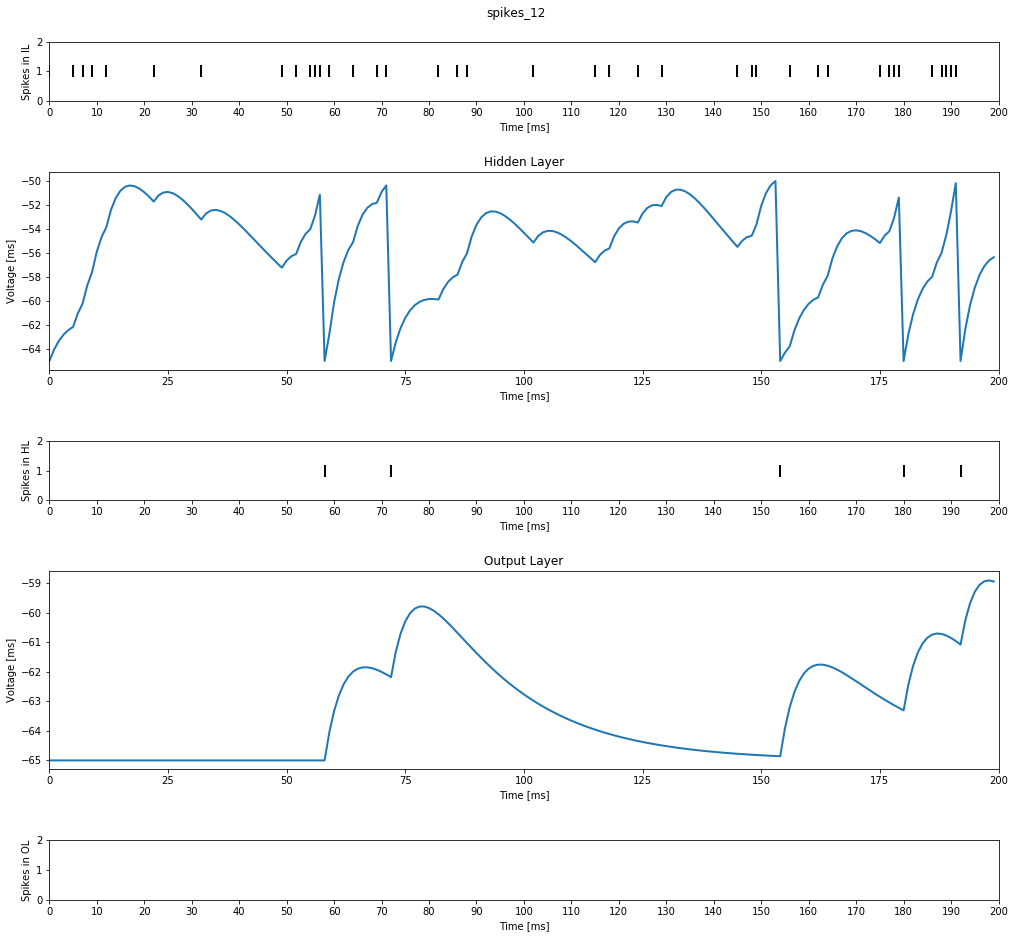

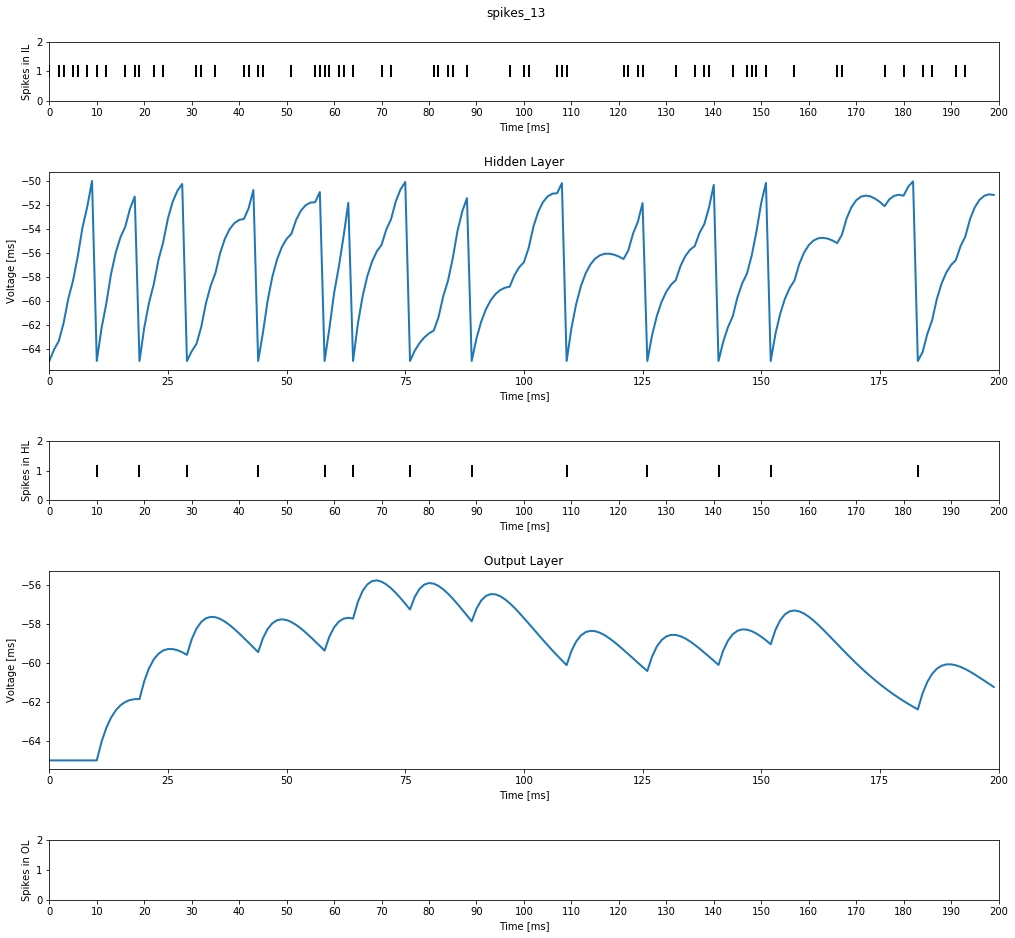

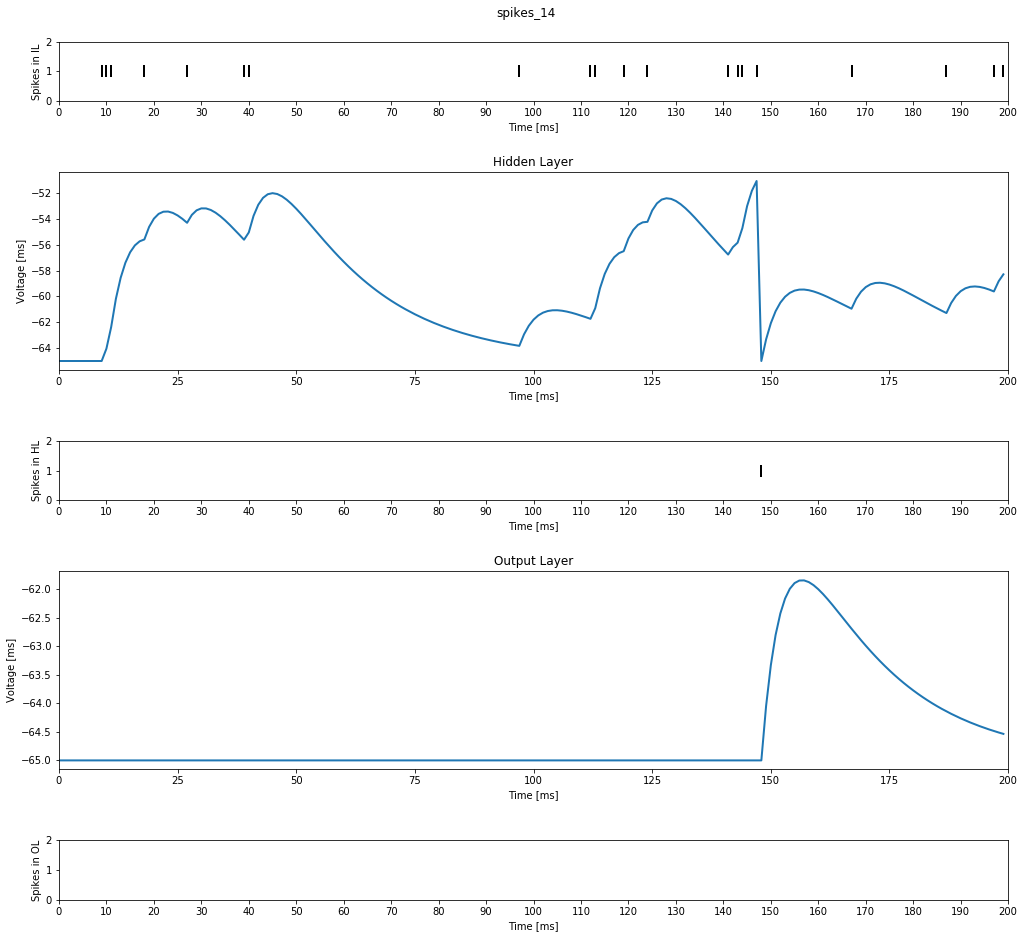

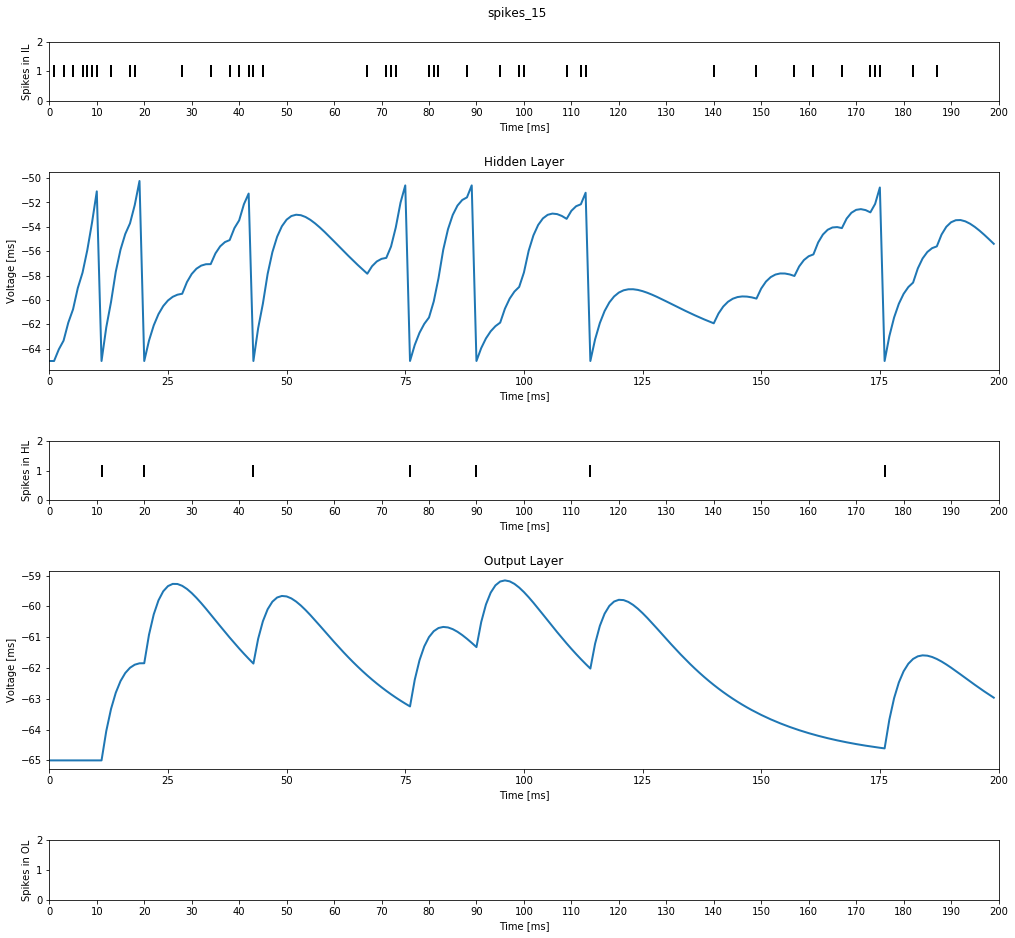

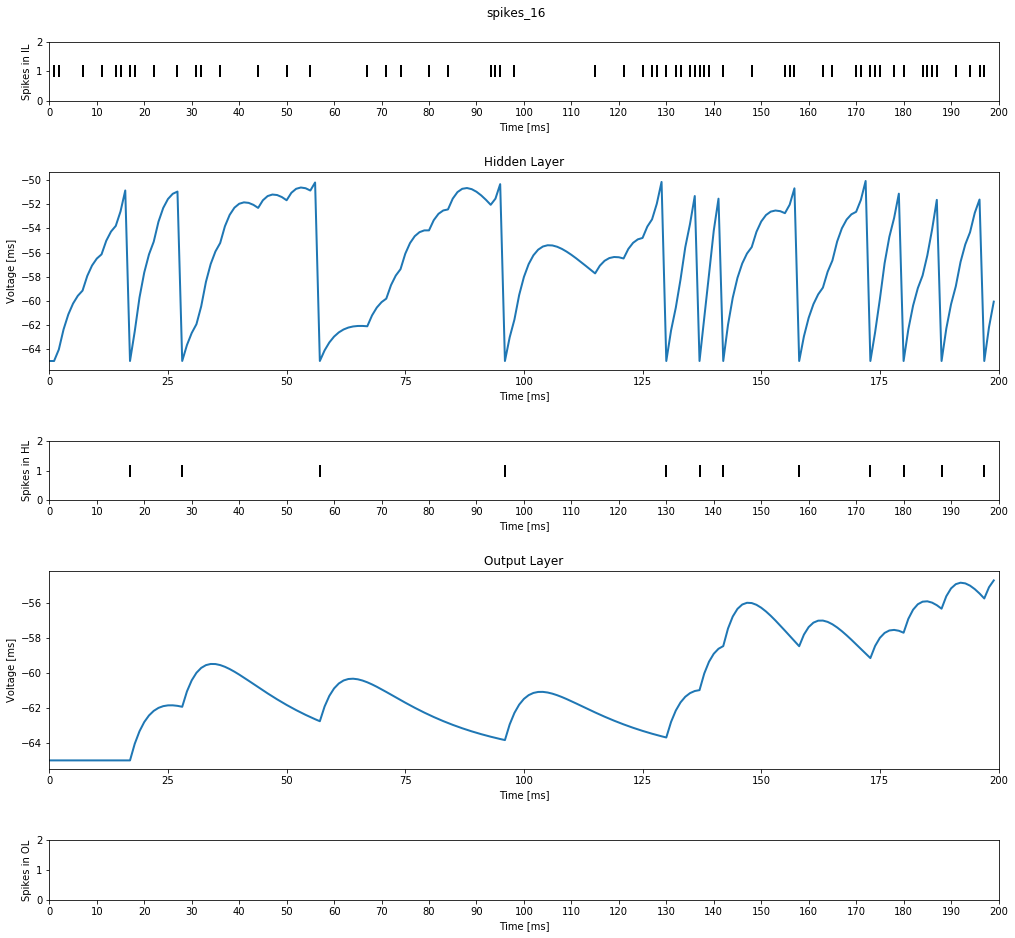

In [5]:
# Fetch available trains of spikes in path
path = "input"
files = fetch_files(path)

# Stack Spike Trains
n = len(files)
spike_trains = np.zeros((nb_steps,n))
for i in range(n):
    
    sfn = files[i].replace("input/","").replace(".csv","")
    
    spike_trains[:,i] = genfromtxt(files[i], delimiter=',')

    # Create Model 
    pathway_1D = Pathway_1D()   

    # Get input data
    i_spikes = spike_trains[:,i:i+1]

    #Run simulation
    o_spikes_ol, v_ol, o_spikes_hl, v_hl = pathway_1D(i_spikes)
    
    #Save Reusuts
    np.savetxt("summary/norse/" + "voltage_hl_" + sfn, v_hl, delimiter=",")
    np.savetxt("summary/norse/" + "output_hl_" + sfn, o_spikes_hl, delimiter=",")    
    np.savetxt("summary/norse/" + "voltage_ol_" + sfn, v_ol, delimiter=",")
    np.savetxt("summary/norse/" + "output_ol_" + sfn, o_spikes_ol, delimiter=",")
    
    # Plot Stuff
    plot_iho(i_spikes, o_spikes_hl, v_hl, o_spikes_ol, v_ol, sfn, nb_steps, pathway_1D.ratio)
        